# Problema da Mochila:

O problema da mochila (em inglês, Knapsack problem) é um problema de optimização combinatória. O nome dá-se devido ao modelo de uma situação em que é necessário preencher uma mochila com objetos de diferentes pesos e valores. O objetivo é que se preencha a mochila com o maior valor possível, não ultrapassando o peso máximo.


O problema da mochila é um dos 21 problemas NP-completos de Richard Karp, exposto em 1972. A formulação do problema é extremamente simples, porém sua solução é mais complexa. Este problema é a base do primeiro algoritmo de chave pública (chaves assimétricas).


Normalmente este problema é resolvido com programação dinâmica, obtendo então a resolução exata do problema, mas também sendo possível usar PSE (procedimento de separação e evolução). Existem também outras técnicas, como usar algoritmo guloso, meta-heurística (algoritmos genéticos) para soluções aproximadas.


# Problema da Mochila - Quantidade limitada de Produtos
## Implementação MPI

In [1]:
import time as t
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

In [2]:
%%writefile ./mochila_mpi.py
# Importando as bibliotecas
import random
import sys
import numpy as np
import math as m
#Importando MPI
from mpi4py import MPI

comm = MPI.COMM_WORLD

#Definindo o rank e o size
rank = comm.rank
size = comm.size
status = MPI.Status()

random.seed(1)

# Definições
TAM_LOJA     = int(sys.argv[1])
QTD_MAX_PROD = int(sys.argv[2])
VAL_MAX_PROD = int(sys.argv[3])
VOL_MAX_PROD = int(sys.argv[4])
CAP_MOCHILA  = int(sys.argv[5])

#Busca combinação pelo indice
def int_comb(valor, base):
    comb = []
    quo = valor
    base.reverse()
    for b in base:
        res = quo % (b+1)
        quo = quo // (b+1)
        comb.insert(0, res)
    base.reverse()
    return comb

#função para retornar um intervalo de valores com os melhores lucros
def int_combs(inicio, fim, loja):
    combs = []
    base = loja['Quantidade']
    for v in range (inicio, fim+1):
        comb = v, int_comb(v, base)
        comb = valor_comb(comb, loja)
        if comb[0] == inicio: # Primeiro valor precisa ser registrado
            combs.append(comb)
        elif comb[2] > combs[-1][2]:
            combs = []
            combs.append(comb)
        elif comb[2] == combs[-1][2] and comb[2]> -1:
            combs.append(comb)
    return combs


#função para retornar o valor da combinação
def valor_comb(comb, loja):
    valores = loja['Valor']
    valor = 0
    volumes = loja['Volume']
    vol = 0
    for i in range(len(valores)):
        valor += comb[1][i] * valores[i]
        vol += comb[1][i] * volumes[i]

    if vol > CAP_MOCHILA:
        valor = -1

    return comb[0], comb[1], valor

#Gerando a loja
def gera_loja(tam_loja, max_preco, max_vol, qtde_max_prod):
    random.seed(12)
    loja = {
        'Produto': [i for i in range(tam_loja)],
        'Valor': [random.randint(1, max_preco) for i in range(tam_loja)],
        'Volume': [random.randint(1, max_vol) for i in range(tam_loja)],
        'Quantidade': [random.randint(1, qtde_max_prod) for i in range(tam_loja)]
    }
    return loja

# Cálculo do custo e volume da combinação
def custo_vol(loja, comb):
    valores = loja['Valor']
    volumes = loja['Volume']
    custo = 0
    vol = 0
    for i in range(len(valores)):
        custo += valores[i] * comb[i]
        vol += volumes[i] * comb[i]
    return (custo, vol)


if rank == 0:

    #Gerando a loja no processo 0
    loja = gera_loja(TAM_LOJA, VAL_MAX_PROD, VOL_MAX_PROD, QTD_MAX_PROD)
    #Divindo o final do intervalo para os processos
    array_quantidade = [value + 1 for value in loja['Quantidade']]
    intervalo = np.prod(np.array(array_quantidade))
    print('Tamanho Intervalo: ', intervalo)
    print()

    intervalo_dividido = m.ceil(intervalo/(size))
    inicio_inicial = inicio = 0
    fim_inicial = fim = intervalo_dividido - 1
    #Enviando valores para gerar as combinações
    print('Processo 0 :', inicio_inicial, fim_inicial)
    for i in range(1, size):
        inicio = fim + 1
        fim = fim + intervalo_dividido
        if fim > intervalo:
            fim = intervalo
        print('Processo ', i, ':', inicio, fim)
        comm.send((inicio, fim, loja), dest=i)
    print()
    #Gerando as combinações
    comb = int_combs(inicio_inicial, fim_inicial, loja)
    print('Melhores combinacoes processo ', rank, ':' , comb)
    max_final = (0, 0)
    max_comb_final = []
    for teste in comb:
        resp = custo_vol(loja, teste[1])
        if resp[0] >= max_final[0] and resp[1] <= CAP_MOCHILA:
            max_final = resp
            max_comb_final = teste[1]

    #Recebendo maiores combinações dos outros processos e comparando com a do processo 0 e entre si
    for i in range(1, size):
        max, max_comb = comm.recv(source=i)
        if max > max_final:
            max_final = max
            max_comb_final = max_comb

    print()
    print('Loja:')
    print('Produtos:    ', loja['Produto'])
    print('Valores:     ', loja['Valor'])
    print('Volumes:     ', loja['Volume'])
    print('Quantidades: ', loja['Quantidade'])
    print()
    print('Combinação máxima:')
    print(max_comb_final)
    print()
    print('Valores Finais (Custo, Volume):')
    print(max_final)
else:
    #Recebendo valores para gerar as combinações
    inicio, fim, loja = comm.recv(source=0)

    #Gerando as combinações
    comb = int_combs(inicio, fim, loja)
    print('Melhores combinacoes processo ', rank, ':' , comb)
    max = (0, 0)
    max_comb = []
    for teste in comb:
        resp = custo_vol(loja, teste[1])
        if resp[0] >= max[0] and resp[1] <= CAP_MOCHILA:
            max = resp
            max_comb = teste[1]

    #Enviando valores para o processo 0
    comm.send((max, max_comb), dest=0)



Overwriting ./mochila_mpi.py


## Teste do código MPI com passagem de parâmetros

In [1]:
# Teste TAM_LOJA, QTD_MAX_PROD, VAL_MAX_PROD, VOL_MAX_PROD, CAP_MOCHILA
!mpiexec -n 6 python mochila_mpi.py 12 7 7 7 43

Tamanho Intervalo:  17418240

Processo 0 : 0 2903039
Processo  1 : 2903040 5806079
Processo  2 : 5806080 8709119
Processo  3 : 8709120 11612159
Processo  4 : 11612160 14515199
Processo  5 : 14515200 17418239

Melhores combinacoes processo  2 : [(7558074, [2, 0, 2, 0, 0, 0, 5, 0, 1, 0, 0, 6], 49)]
Melhores combinacoes processo  0 : [(614977, [0, 0, 2, 0, 1, 0, 5, 0, 1, 0, 1, 6], 51), (615222, [0, 0, 2, 0, 1, 0, 5, 1, 1, 0, 0, 6], 51), (637146, [0, 0, 2, 0, 2, 0, 4, 0, 1, 0, 0, 6], 51), (663445, [0, 0, 2, 1, 0, 0, 5, 0, 2, 0, 1, 6], 51), (663690, [0, 0, 2, 1, 0, 0, 5, 1, 2, 0, 0, 6], 51), (685614, [0, 0, 2, 1, 1, 0, 4, 0, 2, 0, 0, 6], 51), (687462, [0, 0, 2, 1, 1, 0, 5, 0, 0, 0, 0, 6], 51), (735930, [0, 0, 2, 2, 0, 0, 5, 0, 1, 0, 0, 6], 51)]
Melhores combinacoes processo  3 : [(11035674, [3, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 6], 47)]
Melhores combinacoes processo  5 : [(14515289, [4, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 5], 44)]
Melhores combinacoes processo  1 : [(4074517, [1, 0, 2, 0, 0, 0, 5, 0,

## Definição de constantes

In [4]:
TAM_LOJA     = 12
QTD_MAX_PROD = 7
VAL_MAX_PROD = 7
VOL_MAX_PROD = 7
CAP_MOCHILA  = 43

## Fazendo testes de complexidade 
### <font color='Red'>(Execução Demorada!)</font>

In [5]:
# Teste de estresse
tempo_exec=[]
tempo_teorico=[]
for i in range(5, TAM_LOJA+1):
    tempo_atual = t.time()
    # Teste CAP_MOC, TAM_LOJA, QTD_MAX_PROD, MAX_PRECO, MAX_VOL
    string = 'mpiexec -n 6 python mochila_mpi.py '+str(i)+' '+str(QTD_MAX_PROD)+' '+str(VAL_MAX_PROD)+' '+\
                str(VOL_MAX_PROD)+' '+str(CAP_MOCHILA)+' > NUL' #Jogando a saida para null para não poluir o terminal
    !$string
    tempo_final = t.time()
    tempo_final -= tempo_atual
    tempo_exec.append((i,tempo_final))
    #Comparando os resultados com os valores de f(i) = 2*f(i-1)
    tempo_teorico.append((i+1, tempo_final*QTD_MAX_PROD))
#print(tempo_exec)
#print(tempo_teorico)

## Gráfico de complexidade X Tamanho da Loja

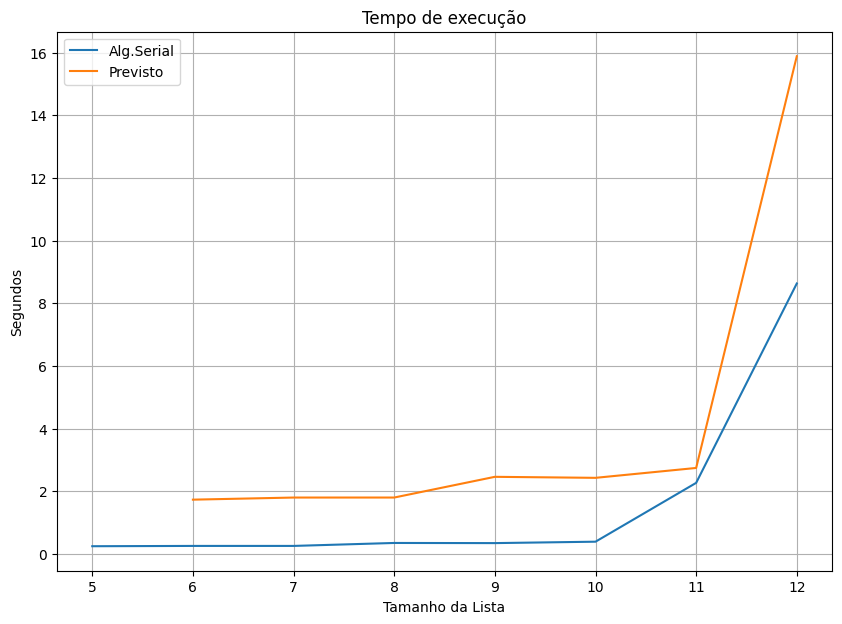

In [6]:
plt.figure(figsize=(10,7))
plt.plot([tempo_exec[i][0] for i in range(len(tempo_exec))], [tempo_exec[i][1] for i in range(len(tempo_exec))], label='Alg.Serial')
plt.plot([tempo_teorico[i][0] for i in range(len(tempo_teorico)-1)], [tempo_teorico[i][1] for i in range(len(tempo_teorico)-1)], label='Previsto')
plt.title('Tempo de execução')
plt.xlabel('Tamanho da Lista')
plt.ylabel('Segundos')
plt.legend()
plt.grid()
plt.show()

## Fazendo testes com constantes definidas (1000 testes) 
### <font color='Red'>(Execução Demorada!)</font>
### Novas constantes para os testes

In [7]:
TAM_LOJA     = 12
QTD_MAX_PROD = 7
VAL_MAX_PROD = 7
VOL_MAX_PROD = 7
CAP_MOCHILA  = 43

In [8]:
TAM_POP   = 1000  # Tamanho da População

In [9]:
# Teste de estresse 2
tempo_exec2=[]
for i in range(TAM_POP):
    tempo_atual = t.time()
    # Teste CAP_MOC, TAM_LOJA, QTD_MAX_PROD, MAX_PRECO, MAX_VOL
    string = 'mpiexec -n 6 python mochila_mpi.py '+str(TAM_LOJA)+' '+str(QTD_MAX_PROD)+' '+str(VAL_MAX_PROD)+' '+\
                str(VOL_MAX_PROD)+' '+str(CAP_MOCHILA)+' > NUL' #Jogando a saida para null para não poluir o terminal
    !$string
    tempo_final = t.time()
    tempo_final -= tempo_atual
    tempo_exec2.append((i,tempo_final))
    print('Execução: %d - Tempo: %.4f seg.' %(i, tempo_final))
#print(tempo_exec2)

Execução: 0 - Tempo: 8.4153 seg.
Execução: 1 - Tempo: 8.5357 seg.
Execução: 2 - Tempo: 9.4122 seg.
Execução: 3 - Tempo: 10.0481 seg.
Execução: 4 - Tempo: 8.3150 seg.
Execução: 5 - Tempo: 8.4516 seg.
Execução: 6 - Tempo: 8.3609 seg.
Execução: 7 - Tempo: 8.4535 seg.
Execução: 8 - Tempo: 8.3933 seg.
Execução: 9 - Tempo: 8.4461 seg.
Execução: 10 - Tempo: 8.3144 seg.
Execução: 11 - Tempo: 8.4905 seg.
Execução: 12 - Tempo: 8.5265 seg.
Execução: 13 - Tempo: 8.7229 seg.
Execução: 14 - Tempo: 9.0505 seg.
Execução: 15 - Tempo: 8.5521 seg.
Execução: 16 - Tempo: 8.6587 seg.
Execução: 17 - Tempo: 8.5280 seg.
Execução: 18 - Tempo: 8.5137 seg.
Execução: 19 - Tempo: 10.0978 seg.
Execução: 20 - Tempo: 8.4589 seg.
Execução: 21 - Tempo: 8.6515 seg.
Execução: 22 - Tempo: 9.0580 seg.
Execução: 23 - Tempo: 8.5099 seg.
Execução: 24 - Tempo: 8.3972 seg.
Execução: 25 - Tempo: 9.2830 seg.
Execução: 26 - Tempo: 8.3763 seg.
Execução: 27 - Tempo: 8.9912 seg.
Execução: 28 - Tempo: 9.5532 seg.
Execução: 29 - Tempo: 

## Transfomando dados para 'numpy' para uso estatístico
<H3><font color='Red'>Só rodar se a célula anterior for executada</font></H3>

In [10]:
tempo_exec2 = np.array(tempo_exec2)
np.savetxt('dataset_multi_core.txt', tempo_exec2, fmt='%f')
#tempo_exec2

# Análise Estatística

## Leitura do Dataset

In [11]:
# Lendo o dataset armazenado
tempo_exec2 = np.loadtxt('dataset_multi_core.txt', dtype = float)

## Gráfico de disperção no tempo de execução

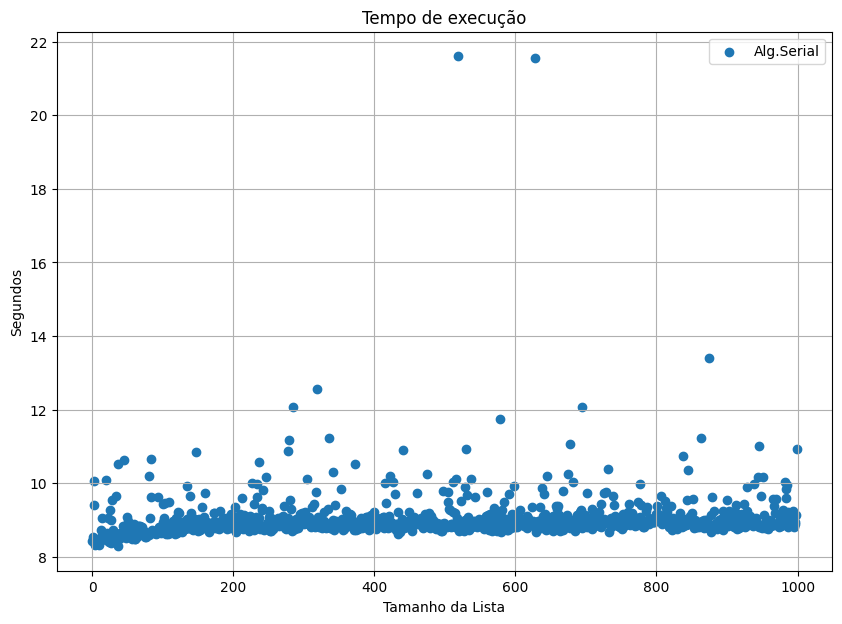

In [12]:
plt.figure(figsize=(10,7))
plt.scatter(tempo_exec2[:,0], tempo_exec2[:,1], label='Alg.Serial')
plt.title('Tempo de execução')
plt.xlabel('Tamanho da Lista')
plt.ylabel('Segundos')
plt.legend()
plt.grid()
plt.show()

## Cálculo de valores centrais:
### (Média, Mediana, Moda)

In [13]:
# Média
tempo_exec2_media = tempo_exec2[:,1].mean()
print('Tempo médio de execução %.4f' %tempo_exec2_media)

Tempo médio de execução 9.0498


In [14]:
# Desvio Padrão
tempo_exec2_std = tempo_exec2[:,1].std()
print('Desvio padrão %.4f' %tempo_exec2_std)

Desvio padrão 0.7227


In [15]:
# Médiana
tempo_exec2_mediana = np.median(tempo_exec2[:,1])
print('Tempo mediano de execuçao %.4f' %tempo_exec2_mediana)

Tempo mediano de execuçao 8.9138


## Análise Frequências

Não é possivel calcular a moda de uma população de valores numéricos contínuos. Neste caso podemos aplicar a **Regra de Sturges** para calcular a frequência da distribuição da amostra.
$$k = 1 + \frac {10}{3}\log_{10}n$$

In [16]:
# Cálculo do intervalo de freqûencia: n = Tamanho da Amostra
n = tempo_exec2.shape[0]
k = 1 + (10/3)*np.log10(n)
k = int(k.round(0))
print(f'Tamanho da Amostra: {k}')

Tamanho da Amostra: 11


In [17]:
# Coletando a frequência
tempo_exec2_freq = np.histogram(tempo_exec2[:,1], bins= k)
print(tempo_exec2_freq)

(array([908,  74,  12,   3,   1,   0,   0,   0,   0,   0,   2], dtype=int64), array([ 8.286485  ,  9.49744936, 10.70841373, 11.91937809, 13.13034245,
       14.34130682, 15.55227118, 16.76323555, 17.97419991, 19.18516427,
       20.39612864, 21.607093  ]))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


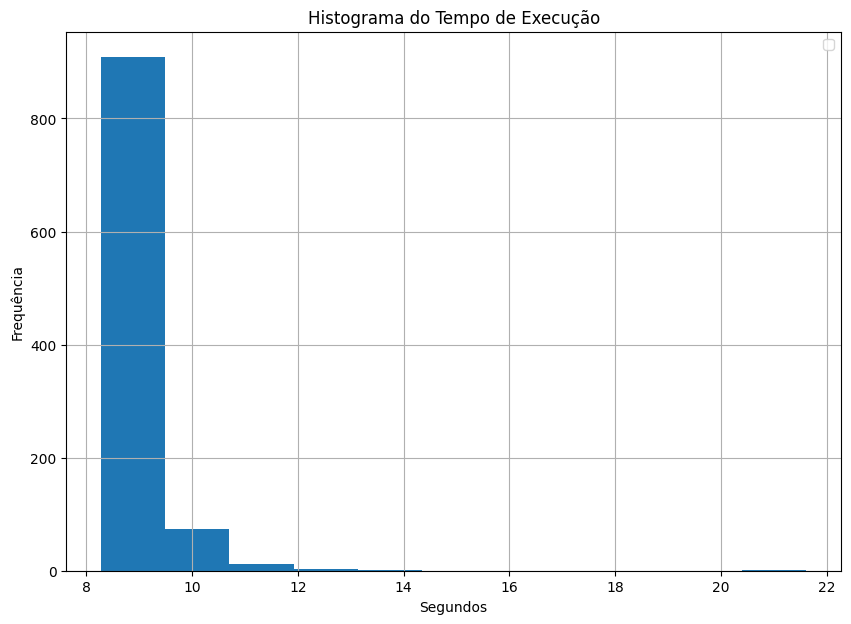

In [18]:
plt.figure(figsize=(10,7))
plt.hist(tempo_exec2[:,1], bins = k)
plt.title('Histograma do Tempo de Execução')
plt.ylabel('Frequência')
plt.xlabel('Segundos')
plt.legend()
plt.grid()
plt.show()

### **Verificando a possbilidade de dados OUTLIERS**
**Medidas Separatrizes**: Quartis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


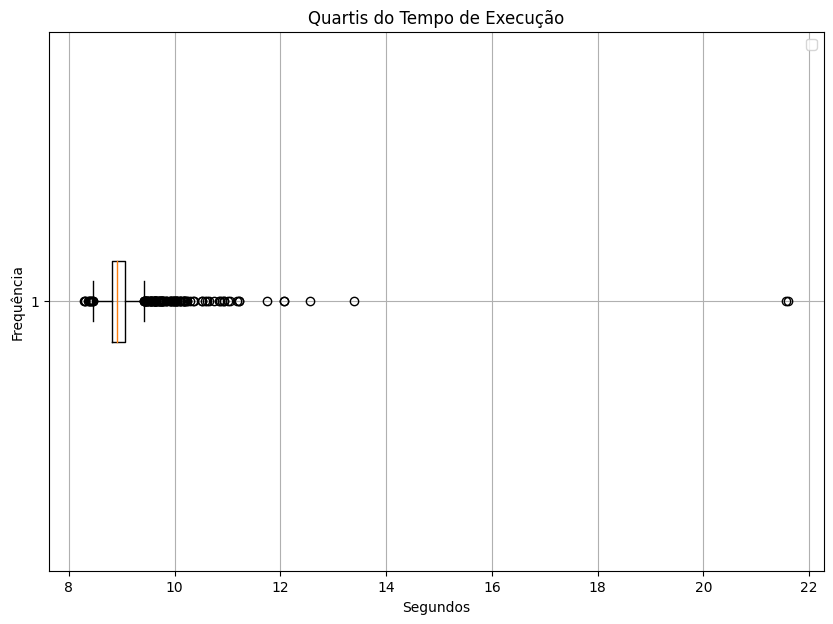

In [19]:
# Gráfico BoxPlot
plt.figure(figsize=(10,7))
plt.boxplot(tempo_exec2[:,1], vert = False)
plt.title('Quartis do Tempo de Execução')
plt.ylabel('Frequência')
plt.xlabel('Segundos')
plt.legend()
plt.grid()
plt.show()

### **Removendo dados "extremos" - Outliers**
#### <font color='Red'> Ajustar os valores antes de executar </font>

In [20]:
# Remover valores da lista
int_sup = tempo_exec2_media + (2 * tempo_exec2_std)
int_inf = tempo_exec2_media - (2 * tempo_exec2_std)
print(f'Nº de registros originais: {tempo_exec2.shape[0]}')
registros = []
for i in range(tempo_exec2.shape[0]):
        if int_inf > tempo_exec2[i, 1] or tempo_exec2[i, 1] > int_sup:
            registros.append(i)
print(f'Qtd. de registros removidos: {len(registros)}')
print(f'Registros removidos: {registros}')
tempo_exec2 = np.delete(tempo_exec2, registros, 0)
print(f'Nº de registros corrigidos: {tempo_exec2.shape[0]}')
print(tempo_exec2[0:15])

Nº de registros originais: 1000
Qtd. de registros removidos: 23
Registros removidos: [37, 45, 83, 147, 236, 277, 279, 284, 319, 336, 373, 440, 518, 530, 578, 628, 677, 694, 837, 863, 874, 945, 999]
Nº de registros corrigidos: 977
[[ 0.        8.415342]
 [ 1.        8.535651]
 [ 2.        9.412212]
 [ 3.       10.048131]
 [ 4.        8.314984]
 [ 5.        8.451591]
 [ 6.        8.360942]
 [ 7.        8.45352 ]
 [ 8.        8.393326]
 [ 9.        8.446144]
 [10.        8.314404]
 [11.        8.490458]
 [12.        8.526457]
 [13.        8.722878]
 [14.        9.050463]]


### Salvando os registros corrigidos

In [21]:
np.savetxt('dataset_multi_core_corrigido.txt', tempo_exec2, fmt='%f')

In [22]:
# Média
tempo_exec2_media = tempo_exec2[:,1].mean()
print('Tempo médio de execução %f' %tempo_exec2_media)

Tempo médio de execução 8.977496


In [23]:
# Desvio Padrão
tempo_exec2_std = tempo_exec2[:,1].std()
print('Desvio padrão %.4f' %tempo_exec2_std)

Desvio padrão 0.3086


In [24]:
# Médiana
tempo_exec2_mediana = np.median(tempo_exec2[:,1])
print('Tempo mediano de execuçao %.4f' %tempo_exec2_mediana)

Tempo mediano de execuçao 8.9086


## Estatística - DISTRIBUIÇÕES DE PROBABILIDADE

### Distribuição Normal

#### Amostra (Média da População)

In [25]:
# Parâmetros para uma media de amostragens
tam_amost = 50
qtd_amost = 1000

In [26]:
# Obtendo a media de amostragens
amostra = []
for i in range(qtd_amost):
    amostra.append(np.random.choice(tempo_exec2[:,1], tam_amost).mean())
amostra = np.array(amostra)

In [27]:
# Valores Centrais da amostragem
amostra_media   = amostra.mean()
amostra_std     = amostra.std()
amostra_mediana = np.median(amostra)
print('** Valores Centrais da Amostra **')
print('Média da amostra:       %.4f' %amostra_media)
print('Desv.Padrão da amostra: %.4f' %amostra_std)
print('Mediana da amostra:     %.4f' %amostra_mediana)

** Valores Centrais da Amostra **
Média da amostra:       8.9804
Desv.Padrão da amostra: 0.0443
Mediana da amostra:     8.9795


In [28]:
# Desvio Padrão de inferência calculado
round(tempo_exec2_std / np.sqrt(tam_amost),4)

0.0436

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


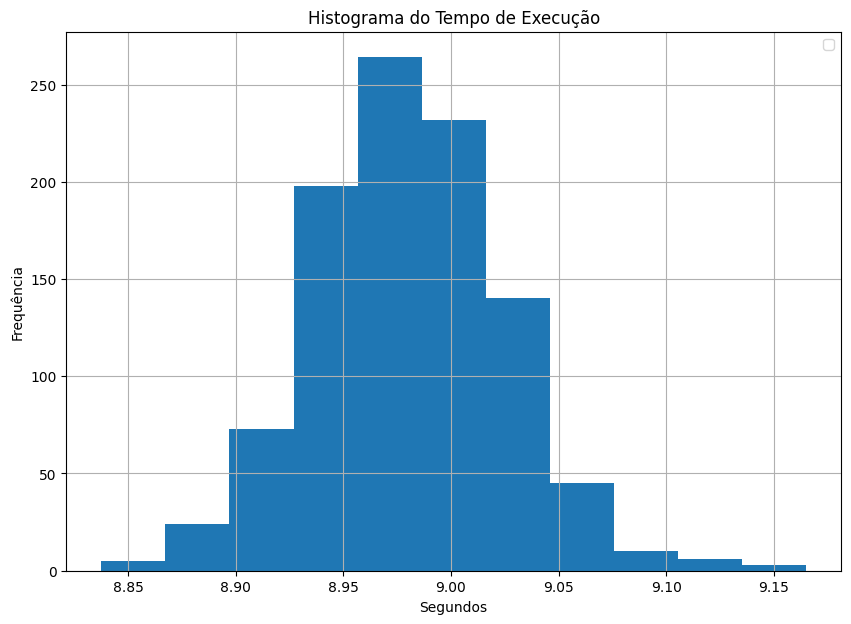

In [29]:
# Visualizando a amostra:
plt.figure(figsize=(10,7))
plt.hist(amostra, bins = k)
plt.title('Histograma do Tempo de Execução')
plt.ylabel('Frequência')
plt.xlabel('Segundos')
plt.legend()
plt.grid()
plt.show()

In [30]:
# Considerando a confiança de 99%
intervalo = norm.interval(alpha = 0.99, loc = amostra_media, scale = amostra_std)

C:\Users\Thiago\AppData\Local\Temp\ipykernel_30224\3257524375.py:2: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  intervalo = norm.interval(alpha = 0.99, loc = amostra_media, scale = amostra_std)


In [31]:
print('Afirma-se que o computador irá executar o Problema da Mochila com os seguintes parâmetros: \n\
        CAP_MOC   = 30    # Capacidade da Mochila \n\
        TAM_LOJA  = 10    # Tamanho da Loja (Variedade de Produtos) \n\
        QTD_MAX_PROD  = 3     # Quantidade limitada de cada produto \n\
        MAX_PRECO = 20    # Maior preço possível \n\
        MAX_VOL   = 10    # Maior volume possível')
print('Com uma média de execução %.4f segundos, oscilando entre %.4f e %.4f segundos, com a certeza de 99%c'\
        % (amostra_media, intervalo[0], intervalo[1], '%'))

Afirma-se que o computador irá executar o Problema da Mochila com os seguintes parâmetros: 
        CAP_MOC   = 30    # Capacidade da Mochila 
        TAM_LOJA  = 10    # Tamanho da Loja (Variedade de Produtos) 
        QTD_MAX_PROD  = 3     # Quantidade limitada de cada produto 
        MAX_PRECO = 20    # Maior preço possível 
        MAX_VOL   = 10    # Maior volume possível
Com uma média de execução 8.9804 segundos, oscilando entre 8.8664 e 9.0945 segundos, com a certeza de 99%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


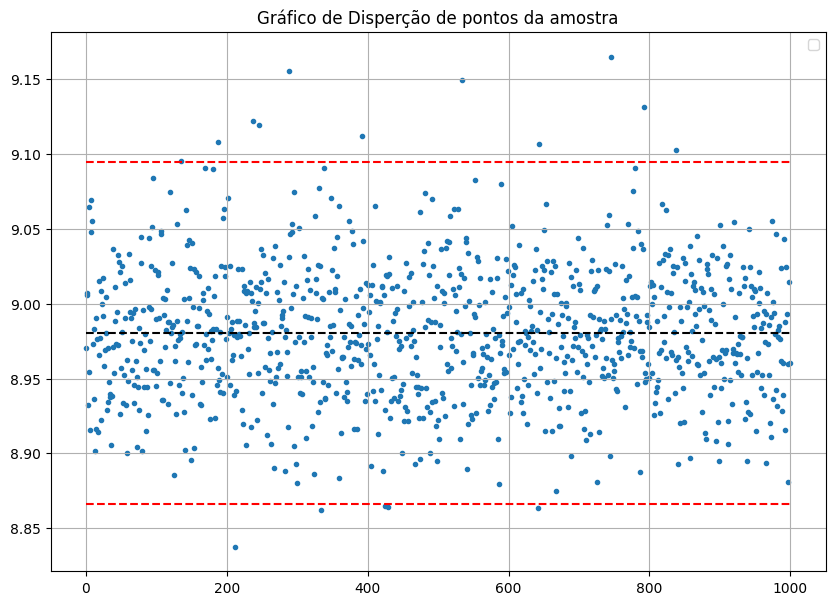

In [32]:
# Visualizando a disperção de Pontos da Amostra
plt.figure(figsize=(10,7))
plt.scatter([i for i in range(qtd_amost)], amostra, marker='.')
plt.hlines(y=intervalo[0], xmin=0, xmax=qtd_amost, color='red', linestyles='dashed')
plt.hlines(y=intervalo[1], xmin=0, xmax=qtd_amost, color='red', linestyles='dashed')
plt.hlines(y=amostra_media, xmin=0, xmax=qtd_amost, color='black', linestyles='dashed')
plt.title('Gráfico de Disperção de pontos da amostra')
plt.legend()
plt.grid()
plt.show()